In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from itertools import combinations

In [2]:
headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}
url = "https://www.transfermarkt.com/statistik/transferrekorde/statistik"
param={'ajax':'yw2',
       'saison_id':"",
       'land_id':0,
       'ausrichtung':"",
       'spielerposition_id':"",
       'altersklasse':"",
       'leihe':"",
       'w_s':"",
       'plus':1,
       'page':0
      }

player_name = []
player_age = []
player_m_value = []
player_tr_fee = []
player_nationality = []
transfer_season = []

for i in range(1,11):
    param['page']+=1
    response = requests.get(url, params = param, headers = headers)
    soup = BeautifulSoup(response.text)
    
    #Get player names
    inline_table = soup.select('table.inline-table')
    for i in range(0,len(inline_table),3):
        player_name.append(inline_table[i].find('img')['alt'])
    
    #Get market value and tranfer fees
    value_fees=soup.select('td.rechts')
    for i in range(0, len(value_fees),2):
        player_m_value.append(str(value_fees[i]).split('">')[1].split('</')[0])
        player_tr_fee.append(str(value_fees[i+1]).split('">')[2].split('</')[0])
    
    #Get other info
    other_info = soup.select('td.zentriert')
    for i in range(0,len(other_info),5):
        player_age.append(str(other_info[i+1]).split('">')[1].split('</')[0])
        transfer_season.append(str(other_info[i+2]).split('">')[2].split('</')[0])
        player_nationality.append(other_info[i+3].find('img')['alt'])
        
df = pd.DataFrame({'Name':player_name,
                   'Nationality':player_nationality,
                   'Age':player_age,
                   'Market Value': player_m_value,
                   'Transfer fee': player_tr_fee,
                   'Transfer season': transfer_season
                  })

In [3]:
#Restriction (a player recorded more than one transfer -> solution: keep only the latest transfer)
df = df.sort_values('Age', ascending=False).drop_duplicates(subset='Name')

## Matching player names with player ids

In [5]:
#Reading file from events list
features_list = pd.read_csv('features.csv', index_col=0)

In [6]:
#Converting names in transfer to a list for further use
transfer_list = df['Name'].to_list()

In [7]:
#Function that create combination of name list 
#reason: player names are written not in full format we need to match
def combine_names(pl_name):
    split_name = pl_name.split()
    comb_list = []
    for r in range(1, len(split_name)+1):
        for comb in combinations(split_name, r):
            comb_list.append(" ".join(comb))
    return comb_list

In [8]:
#Create a list with name cobinations
combination_list = [combine_names(features_list['player_name'][_]) for _ in range(len(features_list))]

In [9]:
#Match the transfer list to get ids from full list
index_list = []
for player in transfer_list:
    for j in range(len(combination_list)):
        if player in combination_list[j]:
            index_list.append((j, player))

In [10]:
#Convert to df and remove names that matched more than 1 combinations
index_list_df = pd.DataFrame(index_list,columns=['idx','Name']) \
                .drop_duplicates(subset='Name', keep=False) \
                .set_index('idx', drop=True)

In [11]:
#Combine with list to get ids
joined_df_id = index_list_df.join(features_list)

In [12]:
#Merge joined list with transfer data
merged_transfer_id = pd.merge(joined_df_id, df, how='left', on = ['Name'])
                              #left_on = 'player_name_', right_on='Name')

In [13]:
#Convert transfer fee from string to float
merged_transfer_id['price']=merged_transfer_id['Transfer fee'].str[1:-1].astype('float')

In [14]:
#Convert transfer fee from string to float
mtm_df=merged_transfer_id[merged_transfer_id['Market Value']!='-']
mtm_df['mtm'] = mtm_df['Market Value'].str[1:-1].astype('float')

/var/folders/hg/r0y8n0n9463dnkb6415p8kh81z03s2/T/ipykernel_39005/2865226629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mtm_df['mtm'] = mtm_df['Market Value'].str[1:-1].astype('float')


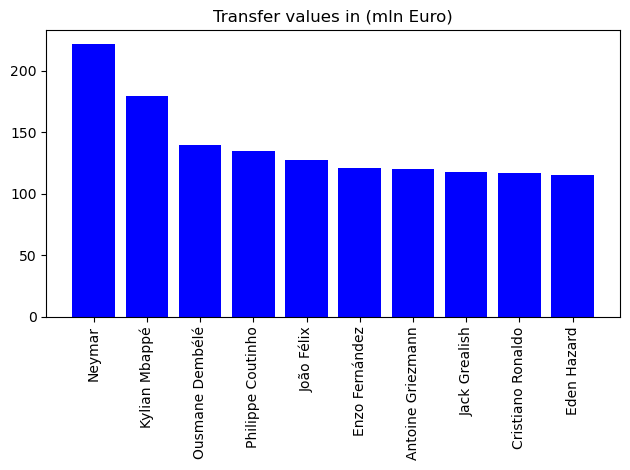

In [44]:
#Bar chart of the top 10 transfers
import matplotlib.pyplot as plt

top_10=merged_transfer_id.sort_values(by='price', ascending=False)[:10]
#.plot.bar(x = 'Name', y = 'price')
X = top_10['Name']
y = top_10['price']
plt.bar(X, y, color='blue')
plt.xticks(rotation='90')
plt.title('Transfer values in (mln Euro)')
plt.tight_layout()

plt.savefig('Player_value_bar.jpeg')

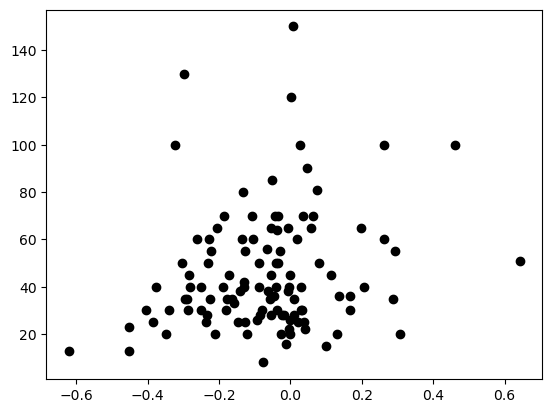

In [16]:
X = mtm_df['weights']
y = mtm_df['mtm']

plt.plot(X, y, 'o', color='k')

In [17]:
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

X = mtm_df[['weights']]
y = mtm_df['mtm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


ridge_poly = Pipeline([('standard_scaler', StandardScaler()),
                    ('poly', PolynomialFeatures()),
                    ('ridge', Ridge())])

svr_poly = Pipeline([
                    ('rfr', RandomForestRegressor())])

param_ridge = {'ridge__alpha': [0.001, 0.01],
              'poly__degree': [1,2,3,4]}
parameters={'rfr__n_estimators': [100, 200, 600],
            'rfr__max_depth':[5, 4, 6, 3]
           }
gs = GridSearchCV(ridge_poly, param_ridge, cv=5, n_jobs = 4)
gs = gs.fit(X_train, y_train)

In [18]:
y_pred = gs.predict(X_test)

In [19]:
gs.best_params_

{'poly__degree': 1, 'ridge__alpha': 0.01}

## Create test df by dropping training values

In [20]:
#Dropping the rows that are in train df
test_df = features_list[~features_list['player_id'].isin(mtm_df['player_id'])].reset_index()

In [21]:
y_pred=gs.predict(features_list[['weights']])

In [22]:
#Estimate predictions
features_list['prediction'] = y_pred

In [23]:
#Export to csv
features_list.rename(columns={'player_name':'Player Name', 'prediction': 
                              'Market Value (mln \u20ac)'}).round(1) \
            .to_csv('soccer_analytics/fair_player_value/fv_estimates.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'soccer_analytics/fair_player_value'